## 1. 评估模型的预测能力

机器学习主要用于预测，评估模型表现至关重要，预测模型分为四类，分别对应不同的验证指标：

1. 分类模型
2. 回归模型
3. 聚类模型
4. 时间序列模型

## 2. 分类模型

### 2.1 混淆矩阵

混淆矩阵(confusion matrix)是展现分类器预测结果的表格，目标变量按不同分类将正确预测和错误预测的个数进行汇总。

与cm相关的术语：

1. true positives(TP)：真阳性，预测值为真，实际结果也为真。
2. true negatives(TN): 真阴性，预测值为假，实际结果也为假。
3. false positives(FP): 假阳性，预测值为真，实际结果为假。
4. false negatives(FN): 假阴性，预测值为假，实际结果为真。

由cm衍生出来的指标：

* accuracy：准确率，正确分类的个数与预测总数的比率。

$$accuracy = \frac{\sum{TP} + \sum{TN}}{\sum{TP} + \sum{TN} + \sum{FP} + \sum{FN}}$$

* precision: 精度，$p(结果为真/预测为真)$，条件概率。

$$precision = \frac{\sum{TP}}{\sum{TP} + \sum{FP}}$$

* recall：召回率，$p(预测为真/结果为真)$，条件概率。

$$recall = \frac{\sum{TP}}{\sum{TP} + \sum{FN}}$$

* F1-score：precision和recall的调和平均。

简单模型，准备预测结果。

In [5]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


iris = datasets.load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data,
                                                    iris.target, 
                                                    train_size = 0.7,
                                                    test_size = 0.3,
                                                    random_state = 123)  # set seed to reproduce result

classifier = DecisionTreeClassifier(max_depth = 2)  # naive model
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

In [6]:
print(y_pred)

[1 2 2 1 0 2 1 0 0 1 2 0 1 2 2 2 0 0 1 0 0 1 0 2 0 0 0 2 2 0 2 1 0 0 1 1 2
 0 0 1 1 0 2 2 2]


计算混淆矩阵。sklearn默认将预测值放在x轴(列)，真实值放在y轴(行)。

In [7]:
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[18  0  0]
 [ 0 10  0]
 [ 0  2 15]]


可视化混淆矩阵。使用sklearn.metrics.plot_confusion_matrix.

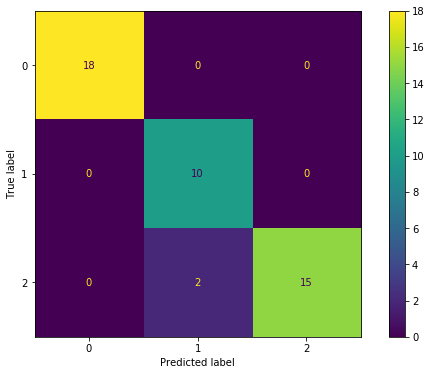

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
metrics.plot_confusion_matrix(classifier, X_test, y_test, ax=ax)

使用seaborn的热力图函数绘制混淆矩阵。

Text(189.2400000000001, 0.5, 'True label')

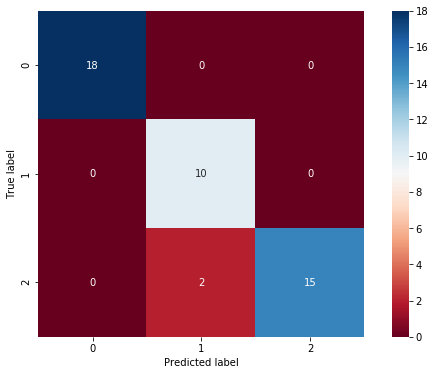

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.heatmap(
    cm,  # n*n矩阵
    cmap="RdBu",  # 调色板，将矩阵数字映射为颜色
    square=True,  # 是否设置每个单元格为正方形
    annot=True,  # 是否添加注解
    fmt="d",  # 注解文字的字符串格式化
    cbar=True  # 是否添加颜色条
)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

计算常用指标。

In [5]:
metrics.accuracy_score(y_test, y_pred)

0.9555555555555556

In [6]:
metrics.precision_score(y_test, y_pred, average=None)

array([1.        , 0.83333333, 1.        ])

In [7]:
metrics.recall_score(y_test, y_pred, average=None)

array([1.        , 1.        , 0.88235294])

综合性报告。

In [8]:
print(metrics.classification_report(y_test, y_pred, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        18
  versicolor       0.83      1.00      0.91        10
   virginica       1.00      0.88      0.94        17

    accuracy                           0.96        45
   macro avg       0.94      0.96      0.95        45
weighted avg       0.96      0.96      0.96        45



### 2.2 ROC

ROC(受试者工作特征曲线)是衡量分类模型预测能力的图形化工具，只能用于二元分类问题。它展现了在不同的概率阈值下真阳性率和假阳性率的关系。横轴是假阳性率(False Positive Rate)，是实际结果为假的情况下预测结果为真的概率，纵轴是真阳性率(True Positive Rate)，是实际结果为真的情况下预测结果也为真的条件概率，也称为召回率。

#### 如何解读ROC？

* ROC包含两条曲线：
    + 连接斜对角线的直线，代表随机分类器的性能，作为参照物。
    + 单调递增的曲线，代表变换概率阈值的时候真阳性率和假阳性率的轨迹。
* (1, 0)代表预测能力为零的分类器。
* (0, 1)代表具有完美预测能力的分类器。
* 曲线下面积称为AUC，是分类器预测性能的综合性指标，通常和随机分类器(AUC = 0.5)或其它模型做比较。

#### 如何应用ROC？

* 对于相同的问题，对比不同模型的ROC和AUC，选择最优的一个。
* 给定模型，根据真阳性率和假阳性率的权衡选择合适的概率阈值。

In [9]:
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
# generate random data
# n_classes ==> number of labels for target variable, in this case it must be binary
X, y = make_classification(n_samples = 1000, n_classes = 2, random_state = 123)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 123)

# fit a naive model
model = KNeighborsClassifier(n_neighbors = 3)
model.fit(X_train, y_train)

# predict probabilities
# change probability threshold to compute different combinations of (TP rate, FP rate)
probs = model.predict_proba(X_test)
probs = probs[:, 1]  # keep probabilities of positive outcomes

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

Text(0, 0.5, 'True Positive Rate')

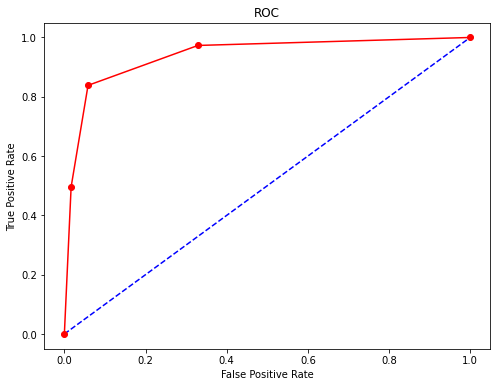

In [11]:
fig = plt.figure(figsize = (8, 6))
plt.plot([0, 1], [0, 1], linestyle = "--", color = "blue")
plt.plot(fpr, tpr, marker = "o", color = "red")
plt.title("ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [12]:
auc = roc_auc_score(y_test, probs)
print("AUC = %.3f" % auc)

AUC = 0.939


## 3. 回归模型

回归模型用于解释和预测被解释变量（通常是数值变量），常用评估指标：

* MAE(Mean Absolute Error) -- 平均绝对误差
* MSE(Mean Square Error) -- 均方误差
* RMSE(Root Mean Square Error) -- 均方根误差
* $R^2$ -- 可决系数

$$MAE = \frac{1}{n}\sum_{i = 1}^{n}|y_i - \hat{y_i}|$$

$$MSE = \frac{1}{n}\sum_{i=1}^n(y_i - \hat{y_i})^2$$

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^n(y_i - \hat{y_i})^2}$$

$$R^2 = 1 - \frac{\sum_{i=1}^n(y_i-\hat{y_i})^2}{\sum_{i=1}^n(y_i-\bar{y_i})^2}$$

对比与说明：

* MAE评估预测值和观测值的绝对偏差，并没有把偏差的方向考虑在内。
* MSE是残差平方和的均值，RMSE是MSE的平方根，是最常用的评估指标。
* 可决系数$R^2$评估模型的拟合优度，是模型对被解释变量的方差的解释程度。
* MAE和RMSE的使用最为广泛，它们的单位与被解释变量的单位一致。MAE并没有考虑偏差方向，RMSE则对异常值非常敏感（考虑平方的计算）。
* 单独看指标数值意义不大，必须跨模型进行对比，数值越低说明模型的预测精度越高。

In [13]:
import numpy as np
from sklearn import metrics

y_true = [1.2, 1.5, 1.8, 2.0, 1.55, 1.54]
y_pred = [1.3, 1.45, 1.65, 2.13, 1.76, 1.67]

mae = metrics.mean_absolute_error(y_true, y_pred)
mse = metrics.mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = metrics.r2_score(y_true, y_pred)

print("MAE = %.4f" % mae)
print("MSE = %.4f" % mse)
print("RMSE = %.4f" % rmse)
print("R2 = %.2f%%" % (r2*100,))

MAE = 0.1283
MSE = 0.0188
RMSE = 0.1372
R2 = 69.98%
